In [85]:
import requests
import re
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

## Pull Data

In [86]:
#pull url
url = 'https://data.cdc.gov/resource/4ueh-89p9.json?$query=SELECT%0A%20%20%60data_as_of%60%2C%0A%20%20%60year%60%2C%0A%20%20%60education_level%60%2C%0A%20%20%60race_or_hispanic_origin%60%2C%0A%20%20%60sex%60%2C%0A%20%20%60age_group%60%2C%0A%20%20%60total_deaths%60%2C%0A%20%20%60covid_19_deaths%60'
r = requests.get(url)

# save data -> convert to df
data = r.json()
df = pd.DataFrame(data)


## Cleaning Data

In [87]:
#convert numeric values from strings
df['total_deaths'] = pd.to_numeric(df['total_deaths'])
df['covid_19_deaths'] = pd.to_numeric(df['covid_19_deaths'])

#using regex to shorten and clarify values
df['age_group'] = df['age_group'].str.replace(" years", "")
df['race_or_hispanic_origin'] = df['race_or_hispanic_origin'].str.replace("Non-Hispanic ", "").str.replace("American Indian or Alaska Native", "Am. Indian").str.replace("More than one race", "Multiracial")
df['education_level'] = df['education_level'].str.replace("Bachelor�s degree or more", "Bachelor's degree or more")

#drop unneccesary frames. Including uknown values and date column for when row was last updated
df = df.drop("data_as_of", axis=1)
df = df.drop(df[df["education_level"] == "Unknown"].index)
df = df.drop(df[df["race_or_hispanic_origin"] == "Unknown"].index)


##New Columns for Proportions

In [88]:
#considering each demographic group, considering each age range
#determining what proportion of deaths of that group were in that age range
#this is also split by year. I want to use 2019 as a pre-covid baseline to then study changes from that baseline with covid
df["prop_dead"] = df.groupby(["education_level", "year", "race_or_hispanic_origin", "sex"])['total_deaths'].transform("sum")
df["prop_dead"] = df["total_deaths"] / df["prop_dead"]

#doing the same thing with proportion but for covid deaths
df["prop_dead_covid"] = df.groupby(["education_level", "year", "race_or_hispanic_origin", "sex"])['covid_19_deaths'].transform("sum")
df["prop_dead_covid"] = df["covid_19_deaths"] / df["prop_dead_covid"]


## Combining data from 2019 and 2020. 

In [89]:
#splitting df intp 2019 and 2020
comb_df = df[df["year"] == "2020"]
other_df = df[df["year"] == "2019"]

# mergining the two years so I have death numbers and proportional deaths for each year in one row.
comb_df = comb_df.merge(other_df[["education_level", "race_or_hispanic_origin", "sex", "age_group","prop_dead","total_deaths"]], 
                        on = ["education_level", "race_or_hispanic_origin", "sex", "age_group"],
                        suffixes=('_2020', '_2019'))
comb_df = comb_df.drop("year", axis = 1)

# making a column to show difference in proportion of deaths per age group in 2019 and proportion of covid deaths in 2020
comb_df["prop_change"] = comb_df["prop_dead_covid"] - comb_df["prop_dead_2019"]

#saving df to csv
comb_df.to_csv("covid_death_demographics.csv", index = False)


##EDA

In [90]:
#What values are in each demographic column?
print(comb_df['education_level'].unique())
print(comb_df['sex'].unique())
print(comb_df['race_or_hispanic_origin'].unique())

#basic summary stats and counts
print(comb_df.describe())

['Associate degree or some college' "Bachelor's degree or more"
 'High school graduate/GED or less']
['Female' 'Male']
['Hispanic' 'Am. Indian' 'Asian' 'Black' 'Multiracial' 'White']
       total_deaths_2020  covid_19_deaths  prop_dead_2020  prop_dead_covid  \
count         214.000000       214.000000      214.000000       214.000000   
mean        15459.341121      1743.070093        0.168219         0.168224   
std         50131.487827      5754.047053        0.147687         0.172858   
min             9.000000         0.000000        0.001032         0.000000   
25%           446.250000        33.500000        0.055666         0.022485   
50%          1710.500000       160.000000        0.139632         0.123526   
75%          9552.750000       907.000000        0.213361         0.253918   
max        530470.000000     59483.000000        0.731280         0.791629   

       prop_dead_2019  total_deaths_2019   prop_change  
count      214.000000         214.000000  2.140000e+02  


#### Looking at proportional changes for younger age ranges based on specific demographics

In [91]:
# Race
print(comb_df[comb_df["age_group"].isin(["0-24","25-39","40-54"])].groupby(["age_group","race_or_hispanic_origin"])["prop_change"].mean())
#Education
print(comb_df[comb_df["age_group"].isin(["0-24","25-39","40-54"])].groupby(["age_group","education_level"])["prop_change"].mean())

age_group  race_or_hispanic_origin
0-24       Am. Indian                -0.036644
           Asian                     -0.019440
           Black                     -0.023628
           Hispanic                  -0.031617
           Multiracial               -0.068377
           White                     -0.008021
25-39      Am. Indian                -0.037238
           Asian                     -0.017456
           Black                     -0.033365
           Hispanic                  -0.036960
           Multiracial               -0.064584
           White                     -0.021134
40-54      Am. Indian                -0.011831
           Asian                     -0.014509
           Black                     -0.018777
           Hispanic                   0.007013
           Multiracial               -0.037895
           White                     -0.032127
Name: prop_change, dtype: float64
age_group  education_level                 
0-24       Associate degree or some colle

#### Visual EDA

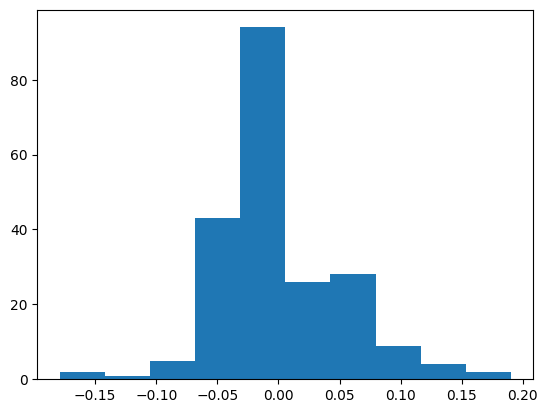

In [92]:
#Basic histogram of proportional changes
plt.hist(comb_df["prop_change"])
plt.show()

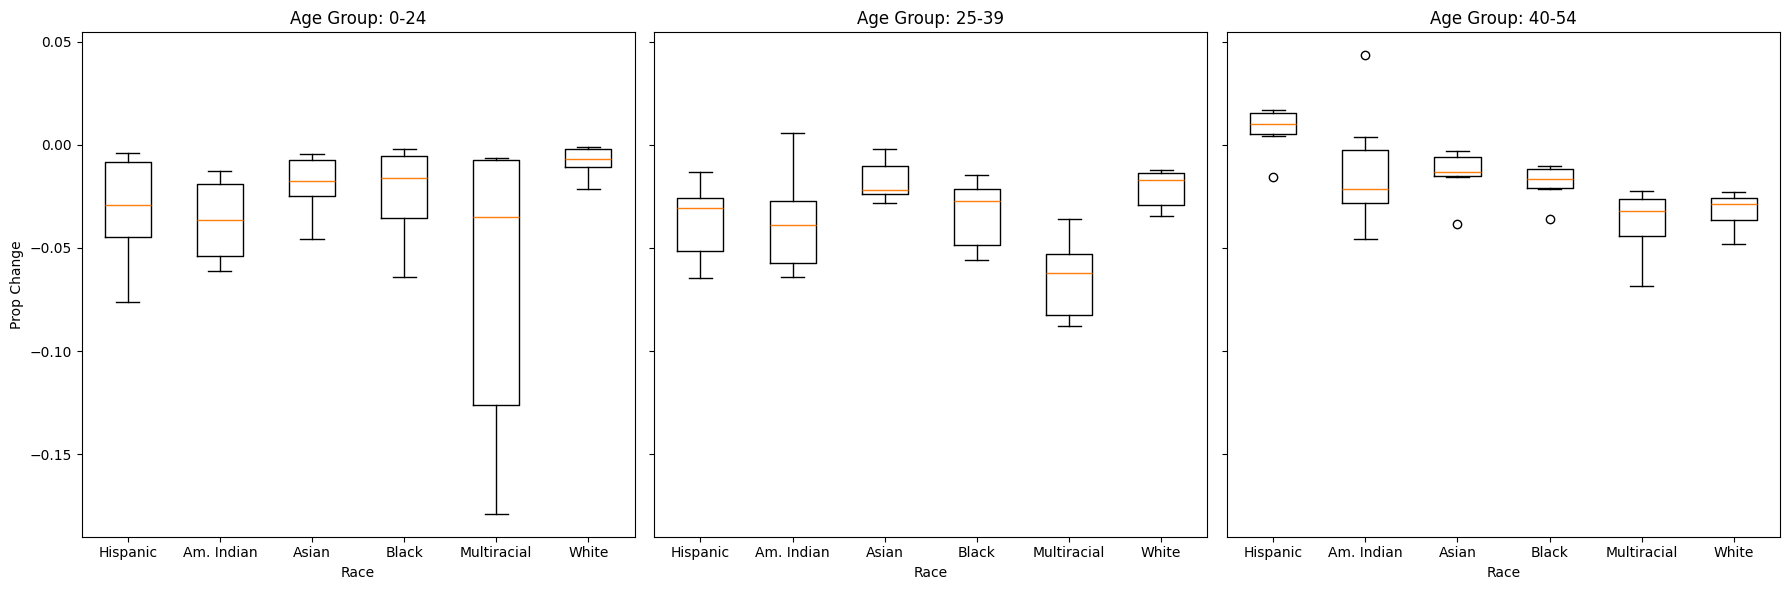

In [95]:
# Getting variables for age range and race
age_groups = comb_df[comb_df["age_group"].isin(["0-24","25-39","40-54"])]["age_group"].unique()
races = comb_df["race_or_hispanic_origin"].unique()

#Preparing sublot structure so I have plot per age range
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

#iterate through age groups. Create boxplots
for i, age in enumerate(age_groups):
    #get data for each race w/in age range
    age_df = comb_df[comb_df["age_group"] == age]
    race_data = [age_df[age_df["race_or_hispanic_origin"] == race]["prop_change"] for race in races]
    
    #create boxplot
    axes[i].boxplot(race_data, tick_labels=races)
    axes[i].set_title(f"Age Group: {age}")
    axes[i].set_xlabel("Race")
    #make y label only appear once
    if i == 0:  # First column of each row
        axes[i].set_ylabel("Prop Change")

plt.tight_layout()
plt.show()

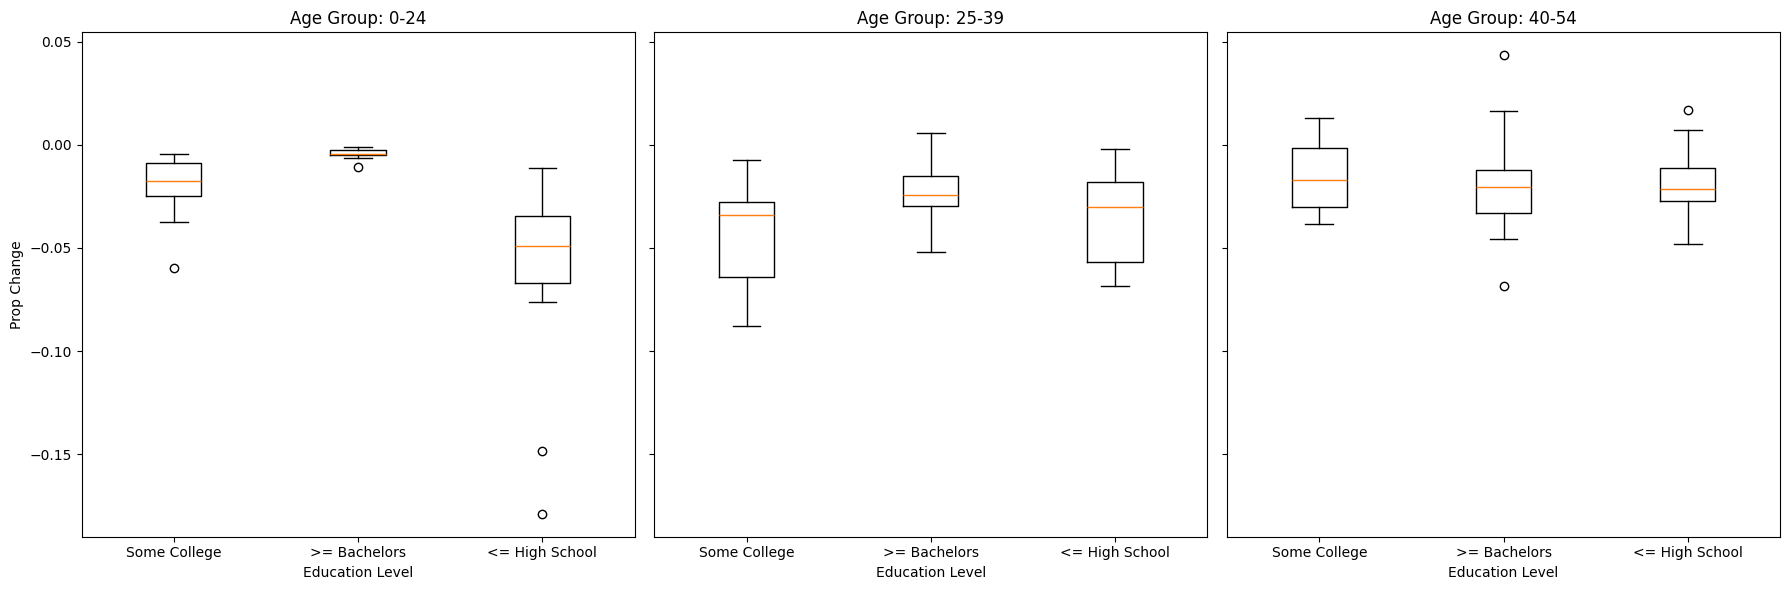

In [97]:
# See above plot for documentation

age_groups = comb_df[comb_df["age_group"].isin(["0-24","25-39","40-54"])]["age_group"].unique()
educations = comb_df["education_level"].unique()

#shortened labels for edu. levels
labs = ["Some College", ">= Bachelors", "<= High School"]

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, age in enumerate(age_groups):
    age_df = comb_df[comb_df["age_group"] == age]
    edu_data = [age_df[age_df["education_level"] == education]["prop_change"] for education in educations]
    
    axes[i].boxplot(edu_data, tick_labels=labs)
    axes[i].set_title(f"Age Group: {age}")
    axes[i].set_xlabel("Education Level")
    if i == 0:  # First column of each row
        axes[i].set_ylabel("Prop Change")

plt.tight_layout()
plt.show()